In [1]:
# 1. import module

import cv2
import os
import time
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle

import numpy as np
from numpy import random as rng
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [2]:
# 2. load data

def load_data(dir_path):
    X = []
    y = []
    lang_dict = {}
    classNo = 0
    for alphabet in tqdm(sorted(os.listdir(dir_path))):
        lang_dict[alphabet] = [classNo,None]
        alpha_path = os.path.join(dir_path,alphabet)
        for letter in sorted(os.listdir(alpha_path)):
            cat_images = []
            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):
                img_path = os.path.join(alpha_path,letter,img)
                cat_images.append(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY))
                y.append(classNo)
            classNo += 1
            X.append(cat_images)
            lang_dict[alphabet][1] = classNo-1
    X = np.array(X)
    y = np.array(y)
    return X, y, lang_dict

image_train_path = '/kaggle/input/omniglot/images_background'
image_eval_path = '/kaggle/input/omniglot/images_evaluation'

trainImages, trainLabels, lang_dict = load_data(image_train_path)
valImages, valLabels, lang_dictVal = load_data(image_eval_path)

100%|██████████| 20/20 [01:16<00:00,  3.85s/it]


964类，每类20个样本，（105,105）

In [3]:
trainImages.shape

(964, 20, 105, 105)

In [4]:
# utility

# get support set and query set
# 构造batch_size 个样本对
def get_batch(batch_size, dataset='train'):
    X = trainImages if dataset == 'train' else valImages

    n_classes, n_examples, w, h = X.shape
    
    # 从964类中抽出 batch_size类
    cat = rng.choice(n_classes, size=batch_size, replace=False)
    
    # 一半同类，一半异类
    targets = np.zeros((batch_size,))
    targets[batch_size // 2:] = 1
    
    # 样本对
    pairs = [np.zeros((batch_size, w, h, 1)) for _ in range(2)]

    for i in range(batch_size):
        # 从当前类 i 中抽取 1 个样本（第 ex_no个）
        ex_no = rng.randint(n_examples)
        pairs[0][i, :, :, :] = X[cat[i], ex_no, :, :].reshape(w, h, 1)
        
        # 抽取另一个样本
        cat2 = 0
        if i >= batch_size // 2:
            cat2 = cat[i] # 正样本
        else:
            cat2 = (cat[i] + rng.randint(1, n_classes)) % n_classes # 负样本
        ex_no2 = rng.randint(n_examples)
        pairs[1][i, :, :, :] = X[cat2, ex_no2, :, :].reshape(w, h, 1)
    return pairs, targets


# N way 1 shot
# 每次抽取N个类别，每个类别 1 个样本， 其中第一个类别作为正例，其他 N-1 个样本作为 负例
def make_one_shot_task(N, dataset='val'):
    X = trainImages if dataset == 'train' else valImages
    
    n_classes, n_examples, w, h = X.shape
    # 抽取N 个类，每个类 1 个样本
    cats = rng.choice(n_classes, size=(N,))
    indices = rng.choice(n_examples, size=(N,))
    
    true_cat = cats[0] # 第一个类
    ex1 = rng.randint(n_examples)
    # 同一个样本复制 N 份
    test_image = np.array([X[true_cat, ex1]] * N).reshape(N, w, h, 1)

    # 从cats类中，每类拿出indices对应位置的样本，即总共 N个样本
    support_set = X[cats, indices].reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    
    test_image, support_set, targets = shuffle(test_image, support_set, targets)
    
    return [test_image, support_set], targets

# get model accuary
def test_one_shot(model, N, k, dataset='val'):
    number_correct = 0
    for _ in range(k):
        inputs, outputs = make_one_shot_task(N, dataset)
        predicts = model.predict(inputs)
        if np.argmax(outputs) == np.argmax(predicts):
            number_correct += 1
    return number_correct / k

In [5]:
# siamese network

def get_siamese(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (5, 5), kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (5, 5), kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='sigmoid', kernel_regularizer='l2'))
    
    left_emb = model(left_input)
    right_emb = model(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb, right_emb])
    OP = Dense(1, activation='sigmoid', kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=OP)
    
    return siamese_net

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          5926528     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential[1][0]             

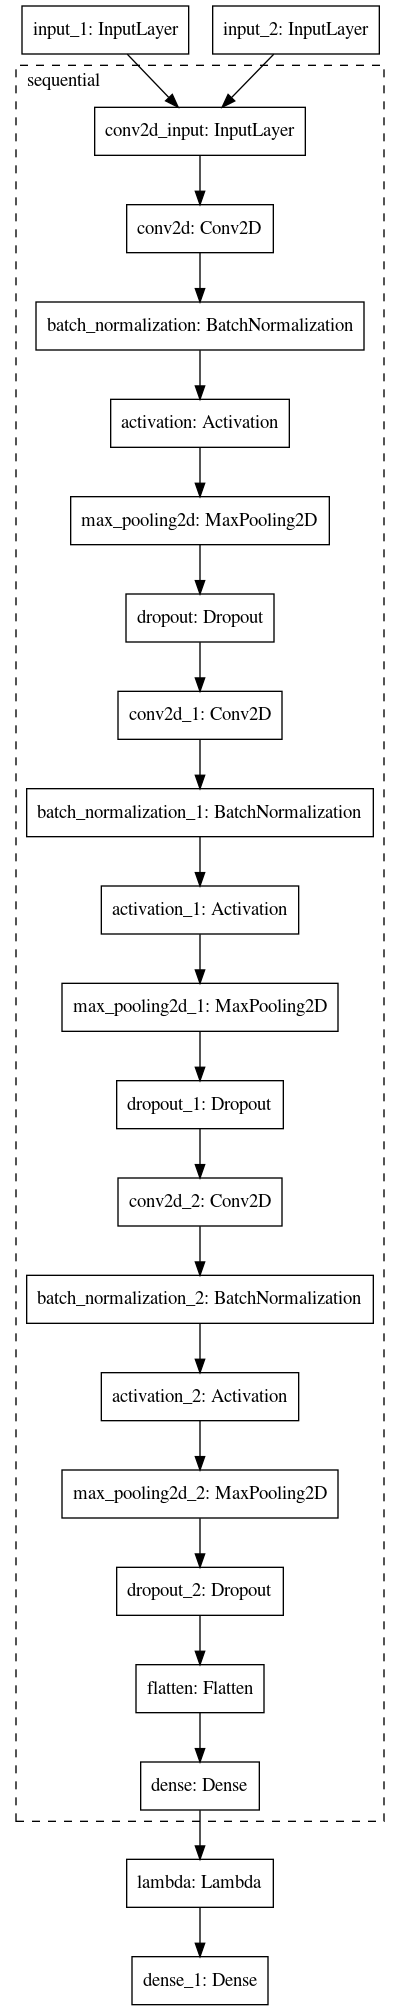

In [6]:
# set parameters

num_iterations = 10000
batch_size = 128
evaluateEvery = 100

k = 250
N = 20

n_classes, n_examples, w, h = trainImages.shape

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=4000,
    decay_rate=0.0001
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = get_siamese((w, h, 1))

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

plot_model(model, to_file='model_plot.png', expand_nested=True)

In [7]:
# training stage

lossArr = []
trainAccArr = []
valAccArr = []
currTime = time.time()
for i in range(0, num_iterations + 1):
    x,y = get_batch(batch_size)
    
    loss = model.train_on_batch(x, y)
    if i % evaluateEvery == 0:
        lossArr.append(loss[0])
        trainAcc = round(test_one_shot(model, N, k, 'train') * 100, 2)
        valAcc = round(test_one_shot(model, N, k, 'val') * 100, 2)
        trainAccArr.append(trainAcc)
        valAccArr.append(valAcc)
        print('Iteration' , i , '(' + str(round(time.time() - currTime, 1)) + 's) - Loss:', loss[0], 'Acc:', round(loss[1], 2), '', end='')
        print(k, str(N) + '-way train accuracy:' , trainAcc, '%, ', end='')
        print(k, str(N) + '-way val accuracy:', valAcc, '%')
        currTime = time.time()

Iteration 0 (20.8s) - Loss: 12.662288 Acc: 0.47 250 20-way train accuracy: 11.2 %, 250 20-way val accuracy: 15.6 %
Iteration 100 (29.2s) - Loss: 7.7829423 Acc: 0.74 250 20-way train accuracy: 36.0 %, 250 20-way val accuracy: 38.4 %
Iteration 200 (29.2s) - Loss: 8.766181 Acc: 0.81 250 20-way train accuracy: 38.0 %, 250 20-way val accuracy: 39.6 %
Iteration 300 (29.3s) - Loss: 5.024097 Acc: 0.79 250 20-way train accuracy: 37.2 %, 250 20-way val accuracy: 41.2 %
Iteration 400 (29.0s) - Loss: 3.4072044 Acc: 0.77 250 20-way train accuracy: 49.6 %, 250 20-way val accuracy: 39.2 %
Iteration 500 (28.7s) - Loss: 2.7690706 Acc: 0.7 250 20-way train accuracy: 38.8 %, 250 20-way val accuracy: 39.6 %
Iteration 600 (29.1s) - Loss: 1.6486549 Acc: 0.79 250 20-way train accuracy: 43.6 %, 250 20-way val accuracy: 44.4 %
Iteration 700 (28.5s) - Loss: 1.4085575 Acc: 0.8 250 20-way train accuracy: 49.6 %, 250 20-way val accuracy: 42.8 %
Iteration 800 (29.5s) - Loss: 1.1757679 Acc: 0.85 250 20-way train acc

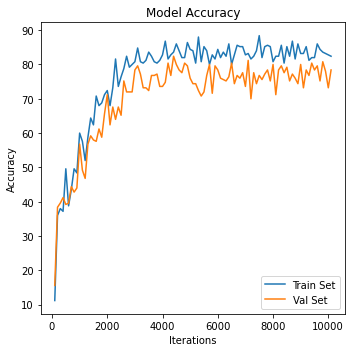

Final Validation Accuracy using 250 20-Way One Shot Learning: 79.6


In [8]:
# plot model performance

epochs_range = [i * evaluateEvery for i in range(1, len(trainAccArr) + 1)]

plt.figure(figsize=(5, 5))

plt.plot(epochs_range, trainAccArr, label='Train Set')
plt.plot(epochs_range, valAccArr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(model, N, k, 'val') * 100, 2))

In [9]:
# store model parameters of architecture

model.save('omniglot-siamese.h5')